# Optimal Transport in Generative Adversarial Networks

Project part 1: **OT-GAN With Sinkhorn Divergence Loss**

----

**Author: Ashraf GHIYE**

----


# OT-GAN

Generative Adversarial Networks, or GANs for short, have gained a lot of interest over the past few years. The reason behind their success is their ability to reproduce synthetic data that looks realistic.

In their essence, a GAN tries to approximate the real data distribution, in the original GAN the loss function is nothing but the Jensen-Shannon divergence between $p_r$ and $p_g$, where $p_r$ is the real data distribution and $p_g$ is the the generated data distribution.

As we shall see, this metric which is based on Kulbeck-Lieber divergence fails to give informative information about the distance between the densities of real and fake data. It is where **Optimal Transport** come into play.

--


In their article [Improving GANs Using Optimall Transport](https://arxiv.org/pdf/1803.05573.pdf), Zhang et al. present Optimal Transport GAN (OT-GAN), a variant of generative adversarial nets by proposing a new metric measuring the distance between the generator distribution and the data distribution. 

This metric, which they call mini-batch energy distance, combines optimal transport in primal form with an energy distance defined in an adversarially learned feature space, resulting in a highly discriminative distance function with unbiased mini-batch gradients. They showed experimentally that OT-GAN can be highly stable when trained with large mini-batches.

In another article variant, [Learning Generative Models with Sinkhorn Divergences](https://arxiv.org/pdf/1706.00292.pdf) the authors presents the
first tractable method to train large scale generative models using an OT-based loss (Sinkhorn loss).

# Summary

This notebook is an implementation of the OT-GAN algorithm, as proposed in the article by Genevay et al. [1] :

Following [1], we use a new loss defined as the Sinkhorn Divergence which is based on Optimal Transport theory and that is very similar to the minibatch energy distance to learn a generative model that generates hand-written digits.

In our case, the cost function is fixed. i.e. the cost is directly computed between the original and generated images and hence we don't need to learn it adversarialy by another network. Therefore, there is only one generator in the model.

**Evaluation:**

In order to test the model, we use the MNIST digit dataset.

**Architecture:**

The architecture suggested by [1] for the MNIST dataset.

<br>

**Side Note:**

We tried to implement [2] but we didn't succeed at generating anything but noise, we believe that the reason behind this was the computational constraint i.e. we only had limited memory and couldn't not use large batch size as proposed by the authors in [2]. In their article they used a huge batch of size 8196 and they argued that their method needs such large batches in order to have stable learning but we couldn't afford a size that is larger than 512.

<br>

However, **the point from their article** is that to avoid a bias in the minibatch gradient that can be found in other approaches based on optimal transport such us in [1]. The distance between the generator and the data distribution is measured by the **mini-batch energy distance** introduced in [2], which is 'highly discriminative' and stable in the sense of the Nash equilibrium (i.e. the results remain consistant if the discriminator stops being updated). The cost function was also learned adversarially by a neural network.

---

References:

[1] Aude Genevay, Gabriel Peyré, Marco Cuturi. Ocotober 2017: **Learning Generative Models with Sinkhorn Divergences** 

[2] Tim Salimans, Han Zhang, Alec Radford, and Dimitris Metaxas. ICLR 2018: **Improving GANs using Optimal Transport** 



## Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml

import matplotlib.pyplot as plt
import seaborn as sns 

import os
import argparse
from datetime import datetime

import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm.auto import tqdm
from torchvision.datasets import VisionDataset
from torchvision import transforms

## Datasets

In [3]:
# Data was stored in our working directory
from google.colab import drive
drive.mount('/content/drive')

path_data = '/content/drive/My Drive/Optimal_Transport/data'  # Data Storage
path = '/content/drive/My Drive/Optimal_Transport/' # Saving Checkpoints 

Mounted at /content/drive


### MNIST digits

- The MNIST training set is composed of 60,000 handwritten digits of size 28 x 28 each.
- Pixels are normalized: values in $[0,1]$.

Reference: http://yann.lecun.com/exdb/mnist/

First, we will download the MNIST dataset and load it as a Torch tensor.

In [ ]:
# Load the training set 
# Define dataset transformation -> Tensors
transform = transforms.Compose([transforms.ToTensor()])

# Download the dataset from drive
n_train_mnist = 60000
trainset_mnist = torchvision.datasets.MNIST(root=path_data, train=True, download=True, transform=transform)

Now, we will inspect the dataset closely..

In [ ]:
# Let's verify the shape
index = np.random.randint(0, n_train_mnist)
print("Shape of the input image : ",trainset_mnist[index][0].shape)

Shape of the input image :  torch.Size([1, 28, 28])


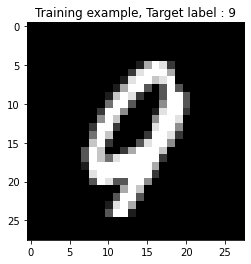

In [ ]:
# Now, let's plot an example
index = np.random.randint(0, n_train_mnist)
plt.figure()
plt.imshow(torch.squeeze(trainset_mnist[index][0], dim=0), cmap='gray')
plt.title("Training example, Target label : "+str(trainset_mnist[index][1]))
plt.show()

## OT-GAN Implementation

Learning Generative Models with Sinkhorn Divergences [[1]](https://arxiv.org/pdf/1706.00292.pdf)

We will use the same parameters proposed by Genevay et al. in the original article (section 4: Applications) to train a generative model on the MNIST digits.

The authors propose to train with mini-batches of size 200. We will run 100 epochs with default values for the Adam optimizers.

For the Sinkhorn algorithm, the author propose to use $\epsilon = 1$ with $L = 10$, It has the same effect as using smaller $\epsilon$ with larger number of iterations.

Finally, we use GPU whenever available to speed-up training.




Comparing to [[2]](https://arxiv.org/pdf/1803.05573.pdf):

- The loss we use, the Sinkhorn divergence, is very similiar to the mini batch energy distance in [2], but we don't sample independant batches. 
- One other major difference is that, as the cost is not learned adversarially by a critic, we only need to train a generator, whose quality is directly assessed by the Sinkhorn divergence between images generated by the the network and real ones. However in [1] they have another experiment in CIFAR-10 with a cost c that is also learned adversarialy.

Hyper-parameters choice

In [5]:
args={}

# Training parameters
args['batch_size'] = 200
args['n_epochs'] = 500


# Optimizer parameters
args['lr'] = 1e-3
args['beta1'] = 0.9
args['beta2'] = 0.999


# Entropy regularization parameters
args['epsilon'] = 1
args['sinkhorn_iter'] = 10

# GPU 
args['cuda'] = True if torch.cuda.is_available() else False
device = "cuda" if args['cuda'] == True else "cpu"
print("GPU is available:", args['cuda'])

GPU is available: True


In [6]:
def plot_gen_images(checkpoint_path, generator, image_size=28, plot_history=False, n=4, device=device):
    """plot images generated by a given model
    Inputs:
    checkpoint_path: path where the model is saved
    generator: initial model
    image_size: either 28 or 32
    plot_history: whether or not to plot the loss evolution
    n: number of sampled examples
    device: cuda or cpu
    """
    # Load in cpu mode by default
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device)) 
    try:
      args = checkpoint['args']
      print('args \n')
      for arg in list(args.keys()):
        if arg == 'n_epochs':
          print(arg, checkpoint['epoch']) 
        else:
          print(arg, args[arg])
    except:
      pass

    generator.load_state_dict(checkpoint['model_state_dict'])

    with torch.no_grad():
      z = generator.generate_noise(n)
      images = generator(z)
      images = images.reshape(n, 1, image_size,image_size)
      fig, ax = plt.subplots(1,n, figsize=(10, 5))
      for i in range(n):
        img = images[i]
        ax[i].imshow(img.numpy().squeeze(), cmap='gray')
      if plot_history:
        plt.figure(figsize=(10,5))
        plt.plot(checkpoint['loss_history'])
        plt.title('Loss evolution')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

Now, let us load the MNIST digits, we will keep their original size (28x28) but we will transform them into torch tensors and define a data loader to generate batches of size `batch_size`.

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
trainset_mnist = torchvision.datasets.MNIST(root=path_data, train=True, download=True, transform=transform)

mnist_loader = DataLoader(trainset_mnist, args['batch_size'], shuffle=True)

Verifying the shape, takes the next batch..

In [ ]:
iter_X = iter(mnist_loader)
X, y = iter_X.next()
print(X.size())

torch.Size([200, 1, 28, 28])


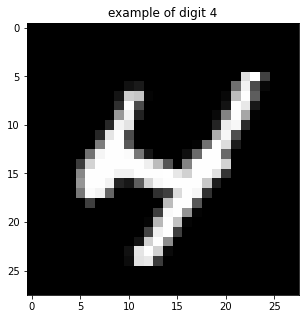

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(X[0].numpy().squeeze(), cmap='gray')
plt.title('example of digit {0}'.format(y[0]))
plt.show()

- We follow the architecture proposed in [1] for the MNIST dataset:

For the neural network, we will only need a generator which is composed of 2-layer MLP architecture as proposed in the article. In our case we made a slight difference i.e. we introduced a second hidden layer of 256 units.
 
Thus our network (generator) is composed of:

- 2 hidden layers of 256 and 512 units respctively.
- 1 output layer of dimension 784 or (28*28) flattened.
- Xavier initialization for the weights. 

We remind the formula for Xavier initialization: Each weight of a layer is initialized following a zero normal distribution with variance $\sqrt{\frac{2}{n_i +n_o}}$ with $n_i$ and $n_o$ respectively the number of inputs and  outputs of the layer. It has been demonstrated empirically that it yields to better stability during training. 



In [9]:
class Generator(nn.Module):
    def __init__(self, input_size=2, hidden_dim_1=256, hidden_dim_2=512, output_size=28*28):
      """Initialize the generator network
      Inputs:
      input_size: dimension of the latent space (z: noise vector of dimension 2) 
      hidden_dim: number of units in the first hidden layer
      output_size: number of units in the last layer -> MNIST digit's dimension
      """
      super(Generator, self).__init__()

      self.input_size = input_size
      self.fc1 = nn.Linear(input_size, hidden_dim_1)
      self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
      self.fc3 = nn.Linear(hidden_dim_2, output_size)

      self.leakyr = nn.LeakyReLU(0.2)
      self.relu = nn.ReLU()
      self.sig = nn.Sigmoid()
      self.tanh = nn.Tanh()

      torch.nn.init.xavier_uniform_(self.fc1.weight)
      torch.nn.init.xavier_uniform_(self.fc2.weight)
      torch.nn.init.xavier_uniform_(self.fc3.weight) 
 
    def generate_noise(self, batch_size):
        """Generate noise with dimension [batch_size, input_size] in a Uniform Square ([0,1]^2)
        """
        z = torch.rand(batch_size, self.input_size)
        return z

    def forward(self, x):
      """Do a forward pass
      """      
      x = self.tanh(self.fc1(x))
      x = self.tanh(self.fc2(x))
      out = self.sig(self.fc3(x))
      return out

In [ ]:
def test_generator():
  """Unit test
  """
  batch_size, noise_dim, output_dim = args['batch_size'], 2, 28*28
  generator = Generator(input_size=noise_dim)

  z = generator.generate_noise(batch_size)
  assert z.size() == (batch_size, noise_dim)
  print(z.size())

  y = generator(z)
  assert y.size() == (batch_size, output_dim)
  print(y.size())

  print("Success.")

test_generator()

torch.Size([200, 2])
torch.Size([200, 784])
Success.


### Sinkhorn Loss

We define the Sinkhorn Divergence as in [1] 

$$\hat{W}_{c,\epsilon}(X,Y) = 2W_{c,\epsilon}(X,Y) - W_{c,\epsilon}(X,X) - W_{c,\epsilon}(Y,Y)$$

where X is a batch of real images and Y is a batch of synthetic images. Note that countrary to the mini batch energy distance defined in [2], we don't sample independant batches X and X' for the second terms.

As for the cost function between samples, the authors used a constant cost function, i.e. $c=||x-y||^2$, since MNIST digits generation is a relatively easy task. For that, we will implement the necessary functions to compute the loss of this OT-GAN.

In [ ]:
def sinkhorn_distance(C, epsilon=1, max_iters=10, a="default", b="default", detach=True, device=device):
    """Sinkhorn's distance
    Inputs : 
    C: the cost matrix (a torch tensor) of size K x K between batch X (K real images) and batch Y (K generated images)
    epsilon: the regularization parameter of the Entropy-regularized Optimal Transport problem, default value is 1
    max_iters: number of iterations for the Sinkhorn's algorithm, default value is 10
    a: either "default" (then a will be initialized to a vector full of 1s) or a torch tensor
    b: either "default" (then a will be initialized to a vector full of 1s) or a torch tensor
    detach: a boolean, whether or not to propagate gradient through Sinkhorn's distance calculation
    device: use gpu in case it is available.
    Output: 
    Float: the Sinkhorn distance between minibatch vectors X and Y
    """

    # Note that in our case we should have m = n (= K in the article's notations) if minibatches are of identical size
    n, m = C.size()
    assert n == m
    
    ## Initialize a and b if necessary
    if a == "default":
        a = torch.ones(n, dtype=torch.float64)/n
    if b == "default":
        b = torch.ones(m, dtype=torch.float64)/m
    
    a = a.to(device)
    b = b.to(device)
    delta = 0

    if detach == True : 
        # Stop gradient propagation during the computation of the distance
        with torch.no_grad():
            # Compute the kernel matrix K
            K = torch.exp(-C/epsilon) + delta

            # Alternate projections
            v = torch.ones(m).to(device)

            for _ in range(max_iters):
                u = a / torch.matmul(K.double(),v.double())
                v = b / torch.matmul(torch.transpose(K,0,1).double(),u.double())

            ## Compute the matching matrix
            M = torch.matmul(torch.matmul(torch.diag(u),K.double()),torch.diag(v))
            return torch.sum(M*C)
    else:
    ## Compute the kernel matrix K
        K = torch.exp(-C/epsilon) + delta

        ## Alternate projections
        v = torch.ones(m).to(device)

        for _ in range(max_iters):
            u = a / torch.matmul(K.double(),v.double())
            v = b / torch.matmul(torch.transpose(K,0,1).double(),u.double())

        ## Compute the matching matrix
        M = torch.matmul(torch.matmul(torch.diag(u),K.double()),torch.diag(v))
        return torch.sum(M*C)

In [ ]:
def cost_matrix(x, y, p=2):
    """Compute the euclidean distance between two batches
    Inputs:
    X and Y: vectors of size (batch_size, n) with n = dimension of each vector 
    Outputs: 
    C: matrix of size (batch_size, batch_size) where C[i,j] is the n-dimensional euclidean distance between X[i,:] and Y[j,:]
    """
    x_col = x.unsqueeze(1)
    y_lin = y.unsqueeze(0)
    c = torch.sum((torch.abs(x_col - y_lin)) ** p, 2)
    return c

def euclidean_dist(X, Y):
    """Compute the euclidean distance between two batches
    Inputs:
    X and Y: vectors of size (batch_size, n) with n = dimension of each vector 
    Outputs: 
    C: matrix of size (batch_size, batch_size) where C[i,j] is the n-dimensional euclidean distance between X[i,:] and Y[j,:]
    """
    norm_X = torch.div(X, torch.norm(X, dim=1, keepdim=True))
    norm_Y = torch.div(Y, torch.norm(Y, dim=1, keepdim=True))

    return torch.cdist(norm_X, norm_Y)**2

Testing the Sinkhorn algorithm with POT package implementation.

In [ ]:
# !pip install POT
# import ot

In [ ]:
batch_size = args['batch_size']

X, _ = iter_X.next()
X = X.reshape(batch_size, -1)
generator = Generator()
Z = generator.generate_noise(batch_size)
Y = generator(Z)

#Verify with OT package
print("Torch implementation:", sinkhorn_distance(euclidean_dist(X,Y), epsilon=1, max_iters=10, device='cpu'))
print("OT package:", ot.sinkhorn2(torch.ones(batch_size)/batch_size, torch.ones(batch_size)/batch_size, euclidean_dist(X, Y).detach(),reg=1))

Torch implementation: tensor(1.2359, dtype=torch.float64)
OT package: [1.23594149]


In [ ]:
def sinkhorn_loss(X, Y, epsilon=1, max_iters=10, detach=False):
    """Compute the sinkhorn loss for the OTGAN when the cost function is the euclidean distance (as in the article)
    Inputs: 
    X: minibatch of real data
    Y: minibatch of generated data
    detach: a boolean, whether or not to propagate gradient through Sinkhorn's distance calculation
    Outputs: 
    loss = total loss
    """

    loss = 2*sinkhorn_distance(euclidean_dist(X,Y), epsilon=epsilon, max_iters=max_iters, detach=detach) 
    loss -= sinkhorn_distance(euclidean_dist(X,X), epsilon=epsilon, max_iters=max_iters, detach=detach) 
    loss -= sinkhorn_distance(euclidean_dist(Y,Y), epsilon=epsilon, max_iters=max_iters, detach=detach) 
    
    return loss

In [ ]:
#saving and loading checkpoints
import shutil

def save_pt(state, checkpoint_dir=path, checkpoint_name='checkpoint_otgan_x.pt'):
    """Saves the state of model
    Inputs:
    state: dictionnary of checkpoint with the models and optimizers parameters
    checkpoint_dir: directory for saving the checpoint
    checkpoint_name: name of the checkpoint 
    """
    f_path = checkpoint_dir + checkpoint_name
    torch.save(state, f_path)
   

def load_pt(checkpoint_fpath, model, optimizer, device=device):
    '''load models from a given checkpoint 
    '''
    checkpoint = torch.load(checkpoint_fpath,  map_location=torch.device(device))

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return  model, optimizer, checkpoint['epoch'], checkpoint['loss_history']

Now we can put all of them together to implement Algorithm 1 in [2]

In [ ]:
def training_OTGAN(args = args, dataloader = mnist_loader, verbose=False, device=device, path=path, checkpoint_name="checkpoint_otgan_vx", plot_digit=True, plot_every=10):
    """Define the training of the OTGAN 
    Inputs: 
    args: dictionnary of arguments for training
    dataloader: dataloader of mnist images 
    verbose: a boolean, wether to print monitoring values during one epoch 
    path: working directory 
    checkpoint_name: name of the checkpoint 
    Outputs:
    the trained Generator
    """

    # Initializations
   
    # Initialize the generator
    generator = Generator().to(device) #default parameters

    # Initialize the optimizers
    optimizer_G = optim.Adam(generator.parameters(), args['lr'], [args['beta1'], args['beta2']])

    # Track loss history
    loss_history = []

    # Number of iterations per epoch. Depends on batch size
    iter_per_epoch = len(iter(dataloader))

    # Batch size
    batch_size = args['batch_size']

    # Number of epochs 
    n_epochs = args['n_epochs']

    
    #----------------------------------------------------

    # Training Loop
    print('\n-----------------')
    print("Initialization:\n")
    print('Learning rate:', args['lr'])
    print('epsilon :', args['epsilon'])
    print('Sinkhorn iterations :', args['sinkhorn_iter'])
    print('Batch size :', batch_size)
    print('Total epochs :', n_epochs)
    print('Iterations per epoch :', iter_per_epoch, '\n-------------------\n\n\n')


    for epoch in range(0, n_epochs):
      # Track loss and steps in each epoch
      total_loss = []
      step = 0

      for real, _ in tqdm(dataloader): # Each iteration corresponds to a batch sampled from dataloader
        # New step
        step += 1

        # Sample real data batch -> send to gpu -> flatten
        real = real.to(device).view(batch_size, -1)

        # Get a uniform noise inside a square [0,1]^2 -> send to gpu
        Z = generator.generate_noise(batch_size).to(device)
        
        # Generate a synthetic images from generator using the noise
        # push-forward mesure g_\theta(Z)
        fake = generator(Z)



        #----------------------------------------------------
    
        # Forward iteration

        # Compute the loss of the network
        loss = sinkhorn_loss(real, fake,  epsilon=args['epsilon'], max_iters=args['sinkhorn_iter'], detach=False)
        

        # Backward step (backpropagation)
        # Re-initialize the optimizer
        optimizer_G.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the weights
        optimizer_G.step()

        # Keep track of the average generator loss in the step
        total_loss.append(loss.item())

        #----------------------------------------------------

        # Detailed monitoring 
        if (step % 100 == 0) and verbose:
          print('\n, Monitoring of iteration {} of epoch {}'.format(step, epoch))
          print('\n--------------------------')
          print('Sinkhorn Loss:', np.mean(total_loss))
          print('--------------------------')

      #----------------------------------------------------

      # Monitoring at the end of epoch
      print('\n\nEpoch {} completed.\n'.format(epoch))
      print('Monitoring', '\n--------------------------')
      print('Sinkhorn Loss:' , np.mean(total_loss))
      if plot_digit == True and epoch%plot_every==0:
        print("Generated digits after epoch "+str(epoch))
        with torch.no_grad():
          n = 10
          image_size = 28
          z = generator.generate_noise(n).to(device)
          images = generator(z)
          images = images.reshape(n, 1, image_size, image_size)
          fig, ax = plt.subplots(1, n, figsize=(20, 10))
          for i in range(n):
            img = images[i].cpu()
            ax[i].imshow(img.numpy().squeeze(), cmap='gray')
            ax[i].axis('off')
          plt.show()
          

      print('--------------------------')
      print('Saving checkpoints..')
      print('--------------------------')

      #----------------------------------------------------

      # Saving checkpoints
      loss_history.append(np.mean(total_loss))

      # Check if model is best so far
      if loss_history[-1] == np.min(loss_history):
        is_best = True
      else:
        is_best = False

      print('best so far?', is_best)

      checkpoint_g = {'epoch':epoch, 'args':args, 'loss_history':loss_history, 'model_state_dict':generator.state_dict(), 'optimizer_state_dict':optimizer_G.state_dict()}
      save_pt(checkpoint_g, checkpoint_dir=path, checkpoint_name=str(checkpoint_name+'_generator.pt'))
      
      #----------------------------------------------------

    trained_model = {'generator': generator}

    return trained_model


-----------------
Initialization:

Learning rate: 0.001
epsilon : 1
Sinkhorn iterations : 10
Batch size : 200
Total epochs : 500
Iterations per epoch : 300 
-------------------








Epoch 0 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.3624097234313802
Generated digits after epoch 0


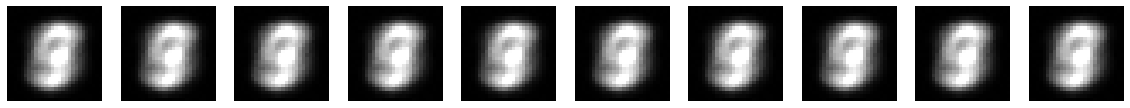

--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 1 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.3078379379540962
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 2 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.22442242386796069
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 3 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.18026648434070605
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 4 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.1611751289179061
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 5 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.14976826098601165
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 6 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.14113777536679875
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 7 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.1339022039453233
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 8 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.12897055528315035
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 9 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.12419836782713309
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 10 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.12000454417977138
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 11 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.11642285117824341
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 12 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.1109570755535406
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 13 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.1080742611040254
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 14 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.10434848265447888
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 15 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.10101612810413506
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 16 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.09870837250884743
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 17 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.09590685701216774
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 18 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.09390100502874404
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 19 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.09182070456650894
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 20 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.08946926223042505
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 21 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0871116893000884
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 22 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.08475517833091331
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 23 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.08370948995777465
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 24 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.08162649150755956
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 25 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.08019255832354699
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 26 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.07856504604586742
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 27 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.07750258493382921
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 28 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.07650378163996005
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 29 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.07492279462484082
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 30 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0737045959841723
Generated digits after epoch 30


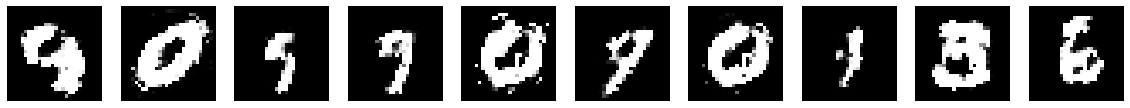

--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 31 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.072738421815241
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 32 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.07106867986456211
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 33 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.07026569415782903
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 34 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.06903242464354219
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 35 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.06862610859349375
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 36 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0674368022750587
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 37 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.06661996661598002
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 38 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0656599717293708
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 39 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.06520923623599902
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 40 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.06416769647487043
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 41 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.06417114284106215
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 42 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.062972816788665
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 43 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.06326926316403446
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 44 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.06261481028349238
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 45 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.06219658525038537
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 46 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.06138803710774537
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 47 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.06065808245148277
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 48 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.06040229243495605
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 49 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.06045619674121793
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 50 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05943666230488318
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 51 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.059672827910596075
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 52 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.058674927063427994
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 53 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05868544501424393
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 54 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.058491806201617653
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 55 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05828993819751301
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 56 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.058005085725220444
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 57 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0572068749293531
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 58 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05696514672337429
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 59 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05654151473154898
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 60 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.056213466882927964
Generated digits after epoch 60


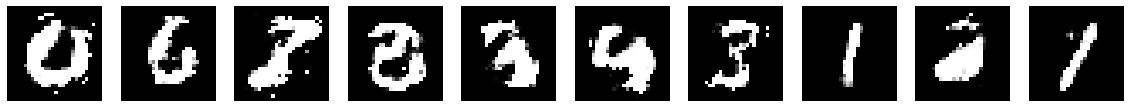

--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 61 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0562643728299574
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 62 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05557119894986569
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 63 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05568396606076592
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 64 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.055730746199929154
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 65 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05519313814240534
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 66 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.054747596249845314
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 67 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05493117387020727
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 68 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05475380086667
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 69 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05412097961858739
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 70 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0540448578659779
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 71 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.054568446386289673
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 72 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05365753345337218
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 73 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.053395344798539184
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 74 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05334374924181522
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 75 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05315744324730265
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 76 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.053671882762921376
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 77 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05367147151442206
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 78 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05314986558676994
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 79 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.053644604155002655
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 80 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.053656662247237474
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 81 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.052622212375552674
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 82 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05262367865843624
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 83 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05268542236985361
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 84 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05206869872518194
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 85 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05241119177633697
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 86 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05236312477022491
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 87 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05259680067200192
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 88 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05173815496905075
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 89 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.051830922391496184
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 90 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.051689700258813524
Generated digits after epoch 90


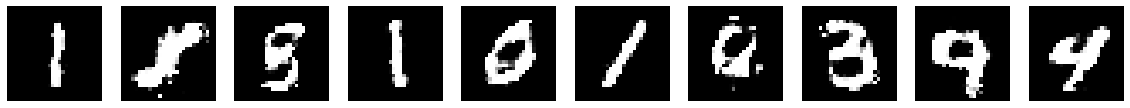

--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 91 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05168503668964283
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 92 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.051671524331839504
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 93 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05128761786624922
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 94 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0508833492124712
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 95 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05156730222892921
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 96 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05123297360989139
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 97 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.051240518450506874
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 98 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.050609844503768396
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 99 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.051365920364470616
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 100 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05118125282134923
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 101 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.050390104362372054
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 102 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.051138932690662164
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 103 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05052061217951663
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 104 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05019576238833194
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 105 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.050867536222984434
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 106 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04985086796323154
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 107 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05023544402807726
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 108 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04981797376433343
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 109 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05000229768439147
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 110 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04979282346664292
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 111 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.050422966119099875
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 112 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.05008184730321781
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 113 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.049979393526292056
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 114 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04965551495351687
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 115 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.049631047054237015
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 116 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04997890674474404
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 117 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.050296109727773576
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 118 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04970304265952276
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 119 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04981042608987667
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 120 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.048976041864553156
Generated digits after epoch 120


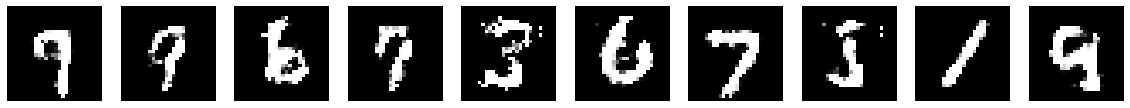

--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 121 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.049102042279549396
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 122 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04963988772841151
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 123 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.049277646989116054
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 124 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04932677873325059
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 125 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04916475417010187
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 126 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.048889319739494536
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 127 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04927707846902387
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 128 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.048993556900066966
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 129 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04884199745080926
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 130 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.048700076563415254
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 131 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04851275034100478
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 132 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04849978714150976
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 133 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.048672734533042536
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 134 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04820621797496404
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 135 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.048647725441682686
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 136 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0484779181534126
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 137 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04838320713556404
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 138 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04862159163960238
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 139 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04879268000854922
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 140 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04806511872900809
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 141 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04776335057497275
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 142 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04815254818148465
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 143 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.047741782772069634
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 144 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.048638801963868196
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 145 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.047735971804159144
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 146 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04831475157552275
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 147 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04854137081066782
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 148 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04769740323234724
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 149 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04760145743424583
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 150 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04792279751102944
Generated digits after epoch 150


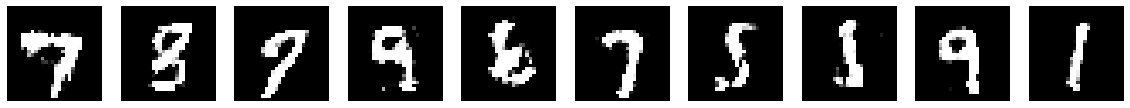

--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 151 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04797984346449893
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 152 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04790063077557815
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 153 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04789549110991243
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 154 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04776232430122766
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 155 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04777467950794253
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 156 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04775748887918804
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 157 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.047888052119728935
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 158 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.048339028436352946
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 159 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04754689855019363
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 160 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04723601369725396
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 161 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0471848426404266
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 162 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04722290135131861
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 163 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04773071208058845
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 164 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04733283872605518
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 165 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.047340155796515675
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 166 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.047429327210497585
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 167 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04709898030949798
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 168 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.047296532098936105
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 169 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0471721758608142
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 170 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0471638202612497
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 171 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.046897599149362056
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 172 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0470623297363947
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 173 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04697919448377295
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 174 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04719495006346565
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 175 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04693551855933797
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 176 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.046937778616310044
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 177 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.047186801479112785
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 178 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0470975684886233
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 179 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.046551377585625435
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 180 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.047182963287580273
Generated digits after epoch 180


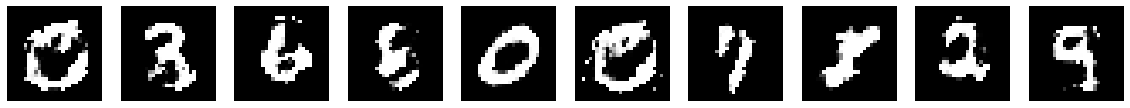

--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 181 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.046826520309628424
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 182 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04697877647560973
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 183 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04679021655864986
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 184 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04704526868215912
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 185 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04654087367283128
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 186 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.046525463745485246
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 187 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04698046777691878
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 188 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04629177000365609
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 189 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.046514006678368434
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 190 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04665562907154146
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 191 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04692452160936645
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 192 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04686443215014411
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 193 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04631932773379144
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 194 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04633309682724985
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 195 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0467494304984877
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 196 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04631469300558793
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 197 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04604255963669306
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 198 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04648137747454372
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 199 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04656428922261103
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 200 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0457544091115373
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 201 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04615726595356507
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 202 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04581021157131817
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 203 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04621608562394345
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 204 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045787625177736734
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 205 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04646945868967592
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 206 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0460135474828066
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 207 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04612888874128288
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 208 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04630263179014076
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 209 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04651127146937475
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 210 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04633421659140713
Generated digits after epoch 210


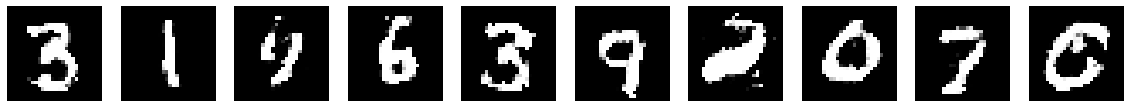

--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 211 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04603647971653384
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 212 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045784962851170466
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 213 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0460612720844087
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 214 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04589868512254536
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 215 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.046328502588318894
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 216 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04607338399934497
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 217 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045567618745801265
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 218 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04569270671000073
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 219 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04567967433995252
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 220 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045905070640192835
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 221 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04578672392244664
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 222 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04574560707874016
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 223 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045749255005403826
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 224 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045695012001246496
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 225 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0457847148872051
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 226 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.046043039785490736
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 227 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044994409418190454
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 228 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04598352052139911
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 229 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04630438364214113
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 230 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04566803486508763
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 231 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0456839766788202
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 232 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04574394125679159
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 233 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04602044184340073
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 234 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0453661528325457
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 235 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04542770432721589
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 236 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04551843382711868
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 237 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04537819279775634
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 238 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045346252663328666
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 239 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04532901163581792
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 240 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04565180241314728
Generated digits after epoch 240


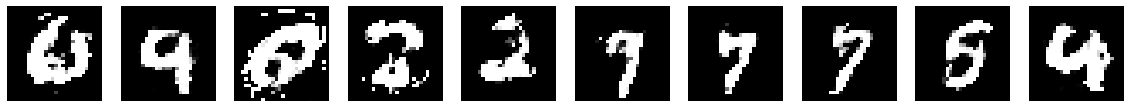

--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 241 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04602744417925803
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 242 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045245745357417516
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 243 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045507193763794064
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 244 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04567949407146982
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 245 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045464207996322135
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 246 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04556258032922822
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 247 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04513393748280396
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 248 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04548236237987926
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 249 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0456499871497551
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 250 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04487159239806148
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 251 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0452884801348203
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 252 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044977846403869745
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 253 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0452075001307152
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 254 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04499769570627799
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 255 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04514162935358895
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 256 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045577717238305504
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 257 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04512200756804002
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 258 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045324571420466524
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 259 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04546342709790672
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 260 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04521375679123746
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 261 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045264998824843694
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 262 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0454685906407703
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 263 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045073451385537
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 264 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04455710972846751
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 265 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04536901452444355
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 266 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0451328441675843
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 267 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044968490904889066
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 268 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04495193228248396
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 269 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04545687718652893
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 270 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04474764348258773
Generated digits after epoch 270


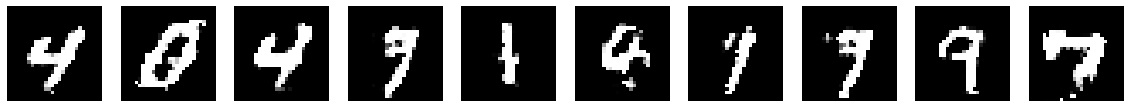

--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 271 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0447359940385833
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 272 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045025322159393096
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 273 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04433909639257818
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 274 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04479779688808676
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 275 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04512709268085737
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 276 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04498995748152226
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 277 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04526743000811619
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 278 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044496582589662735
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 279 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04452265290596304
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 280 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0451181192167173
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 281 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04478499501476931
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 282 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044628076515466464
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 283 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04489346490847452
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 284 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04479807322031002
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 285 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0450671621027863
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 286 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0446924588720434
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 287 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0445636127962997
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 288 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04435480266034289
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 289 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04484477049785977
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 290 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04487940763627566
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 291 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04458599813831301
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 292 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04446128849810162
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 293 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04470505796856171
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 294 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04471772331070596
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 295 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04474431183958144
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 296 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04473389719297824
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 297 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04460115704319053
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 298 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0447504695069782
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 299 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04433132930818983
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 300 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044174763516542585
Generated digits after epoch 300


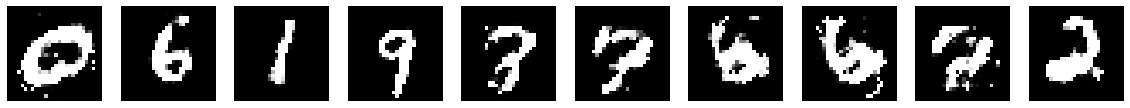

--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 301 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044205060393729456
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 302 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04467446163094209
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 303 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.045195393828118144
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 304 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04452875862036066
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 305 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044222276389848054
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 306 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04469292143883218
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 307 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04414085213132302
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 308 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04438869687007039
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 309 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0445311312943204
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 310 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04444028903873446
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 311 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04440804736608127
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 312 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0446354349559385
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 313 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04461831838206864
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 314 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04414898037911357
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 315 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044547811778119964
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 316 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04423343254996509
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 317 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04460446082541548
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 318 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04429394153020984
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 319 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04418525509220338
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 320 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044566955860677715
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 321 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044712812078459264
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 322 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04403905859331614
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 323 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044403586958343184
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 324 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044270009213131775
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 325 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044165248168950046
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 326 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04491761166793801
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 327 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04420364918167538
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 328 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043929785915816276
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 329 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044512315306675536
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 330 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04454455625889652
Generated digits after epoch 330


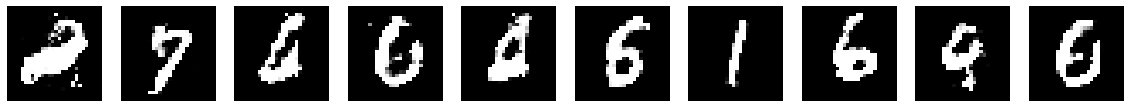

--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 331 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044215881306313466
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 332 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04470193798587915
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 333 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044187858644054195
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 334 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04393772129455512
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 335 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044181923066028674
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 336 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044195272595568144
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 337 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044510037784774484
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 338 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04396057107440322
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 339 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04434523909054286
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 340 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04448914264175735
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 341 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04485124852140499
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 342 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044543048193993406
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 343 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04431306526407888
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 344 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04425001907132109
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 345 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044104349305815825
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 346 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04368965226609693
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 347 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04428180703208128
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 348 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04413345532919974
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 349 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04435278496009356
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 350 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04376430720141097
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 351 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04429288956009422
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 352 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04389322004761437
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 353 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04443479871054377
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 354 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044207905513261266
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 355 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04395718395639992
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 356 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04391963753032921
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 357 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04343235566079737
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 358 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04371287019992907
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 359 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04416260849420499
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 360 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04384376697260251
Generated digits after epoch 360


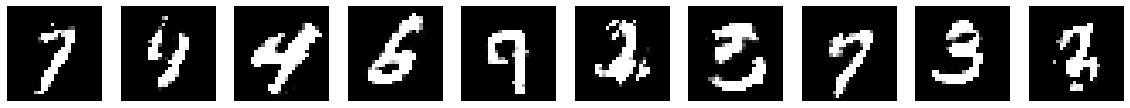

--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 361 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04384907287459761
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 362 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043518610221390974
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 363 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044232853631805895
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 364 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04370152155817322
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 365 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044151603989466916
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 366 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04442727833289047
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 367 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04389580403510743
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 368 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04395345595950368
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 369 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04392171298898349
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 370 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04419835010713517
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 371 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044044647684528516
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 372 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043476168545317814
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 373 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04368693975353944
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 374 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04394978017682122
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 375 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04378339881545868
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 376 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04394116828996668
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 377 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043916237373357765
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 378 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04368245023233668
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 379 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04387352154886635
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 380 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043992234747590425
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 381 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043800624742667243
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 382 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04398002681610018
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 383 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043822119772029745
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 384 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044050336621578944
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 385 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04357246415653665
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 386 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043576666480832055
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 387 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04414560430438584
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 388 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04404359380935924
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 389 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044141362292211495
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 390 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043664995486410105
Generated digits after epoch 390


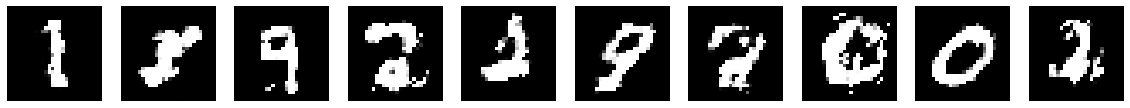

--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 391 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04356624595350604
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 392 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04388462272746501
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 393 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04343220142629817
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 394 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04385098497877609
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 395 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043454910999626443
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 396 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04356700512450741
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 397 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04390663800077023
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 398 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04376314026620978
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 399 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04421752528445455
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 400 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04396965282729767
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 401 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0436727026710491
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 402 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043885052573122925
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 403 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04345976162653352
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 404 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043941324460174895
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 405 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043438187303993354
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 406 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043728167766025526
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 407 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04405205676255046
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 408 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.044263910669097295
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 409 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04338322256991683
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 410 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043369147573398485
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 411 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04390928642123772
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 412 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04325094886499274
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 413 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04357987949788409
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 414 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043662383778306064
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 415 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04348615567738084
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 416 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04359415997394616
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 417 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04396919753790748
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 418 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0434964644180778
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 419 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04370579949520132
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 420 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0436845144428053
Generated digits after epoch 420


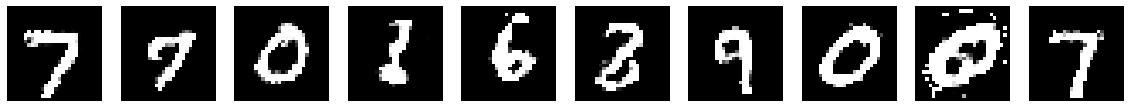

--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 421 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04325251175442079
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 422 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04398184256550447
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 423 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043664168379673594
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 424 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043658409168634726
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 425 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043666463164096204
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 426 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04357286048190872
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 427 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04316594840251729
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 428 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04364339100822519
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 429 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04354382304931639
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 430 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04348105703713168
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 431 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043281645726610696
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 432 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04362991501878976
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 433 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043514188490329966
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 434 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04332643260461478
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 435 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043522544023094155
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 436 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04356841331099878
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 437 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043901391013417314
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 438 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043363162676539634
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 439 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043545790159633044
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 440 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.042792989239985826
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 441 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04374363379609487
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 442 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04338656535546136
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 443 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04344589533182296
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 444 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04311465981838885
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 445 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04312652872519189
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 446 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04363301405042889
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 447 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04312288385298076
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 448 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04352470666557475
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 449 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04359480890703515
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 450 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043228810337870134
Generated digits after epoch 450


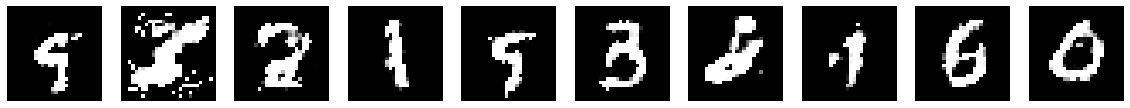

--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 451 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043989933210153556
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 452 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04324554484135111
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 453 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04336570800501296
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 454 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04325826471666664
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 455 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04341495389575335
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 456 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04367776384347489
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 457 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04343197711963043
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 458 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04344841309843374
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 459 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04331309799672318
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 460 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043878526664441704
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 461 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04372311601139356
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 462 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043349010156584655
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 463 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043519933010156935
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 464 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04272462479297844
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 465 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04409909663337993
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 466 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043370887511240755
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 467 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043074804738262015
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 468 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043367017510379496
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 469 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04330092372783226
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 470 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043082965107027305
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 471 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04324633643036434
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 472 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043211315786946924
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 473 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0429557494902373
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 474 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04352248674796695
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 475 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043866068539137965
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 476 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043638405936602453
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 477 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04357007845089999
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 478 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04352231327641061
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 479 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043346982399928506
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 480 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043255926985246884
Generated digits after epoch 480


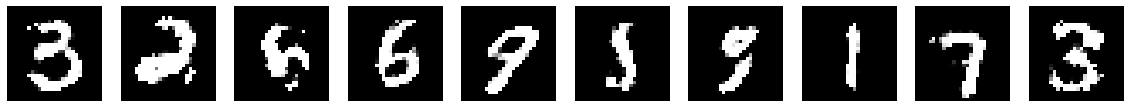

--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 481 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0429833384571294
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 482 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043371831713850485
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 483 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04335958964977684
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 484 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04303740870891339
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 485 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04338738254049652
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 486 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04246076059097643
--------------------------
Saving checkpoints..
--------------------------
best so far? True





Epoch 487 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04304569352678379
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 488 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04317152049036857
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 489 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04371036542126114
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 490 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043542483157044336
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 491 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043085628149444305
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 492 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04308428174103693
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 493 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.0433034583276597
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 494 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04347889749394358
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 495 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04344370945019892
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 496 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.043537672598598885
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 497 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.042947982266363594
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 498 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04312661530062744
--------------------------
Saving checkpoints..
--------------------------
best so far? False





Epoch 499 completed.

Monitoring 
--------------------------
Sinkhorn Loss: 0.04300471805083595
--------------------------
Saving checkpoints..
--------------------------
best so far? False


In [ ]:
trained_model = training_OTGAN(args=args, dataloader=mnist_loader, plot_digit=True, plot_every=30, path=path, checkpoint_name='checkpoint_bis_otgan_v1')

args 

batch_size 200
n_epochs 499
lr 0.001
beta1 0.9
beta2 0.999
epsilon 1
sinkhorn_iter 10
cuda True


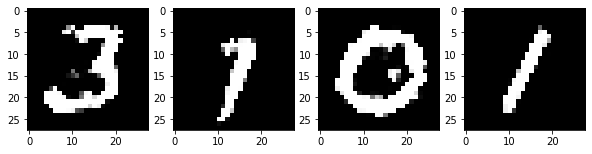

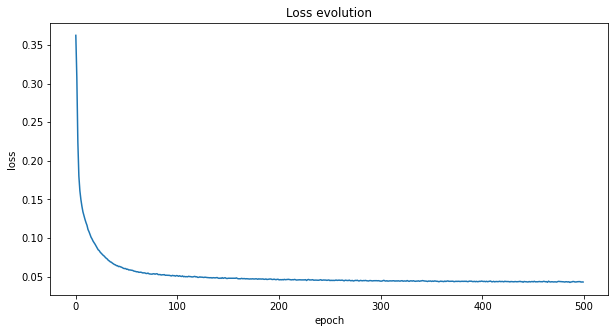

In [ ]:
checkpoint_path = path + 'checkpoint_bis_otgan_v1_generator.pt'
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

After testing with different hyper-parameters, we conclude the following:

- A too small learning rate is not good. We decided to stick to Adam default value ie 0.001
- Our best results are with $\epsilon = 1$ and a number of iterations of 10 or 100. (as proposed by the article)
- Better keep a large batch size.
- Note that we can't compare the losses for different value of $\epsilon$ as the Sinkhorn distance depends on it $\left(K = exp \left(\frac{-K}{\epsilon}\right ) \right)$

### Exploring the latent space

We will now test some interpolations in the latent space. That is we will see that if we took two points $z_1$ at the lower hand and $z_2$ on the right hand corresponding the different images and then interpolate between these two in the latent space, what is the resulting image with the pushforward measure i.e. generated result.


This kind of application is interesting for example in medical imaging, where having at both ends the representation of two CT scans, one shows a healthy patient and the other with tumor, then interpolating the latent space will help track the evolution of the tumor in the image.

In [115]:
def plot_interpolation(checkpoint_path, generator, z_dim=2, image_size=28, n_transitions=10, batch_size=10):
    """plot images generated by a given model

    Inputs:
    checkpoint_path: path where the model is saved
    generator: initial model
    z_dim: dimension of the noise space
    image_size: either 28 or 32
    n_transitions: number of points to slice each dimension of the square [0,1]
    batch_size: number of images to generate
    """
    # Load in cpu mode by default
    checkpoint = torch.load(checkpoint_path) 
    try:
      args = checkpoint['args']
      print('args \n')
      for arg in list(args.keys()):
        print(arg, args[arg])
    except:
      pass

    generator.load_state_dict(checkpoint['model_state_dict'])


    fig, ax = plt.subplots(batch_size, n_transitions, figsize=(n_transitions, batch_size))
    fig.subplots_adjust(wspace=0, hspace=0)
  
    with torch.no_grad():
      percent_first_noise = torch.linspace(0, 1, n_transitions)[:,None]
      for i in range(batch_size):
        first_noise = torch.rand(1, z_dim)
        second_noise = torch.rand(1, z_dim)
        for j in range(n_transitions): 
          interpolation_noise = first_noise * percent_first_noise[j] + second_noise * (1 - percent_first_noise)[j]

          # Generate image by running (sampling) the generator
          img = generator(interpolation_noise)

          img = img.reshape(1, image_size, image_size)
          if batch_size > 1:
            ax[i,j].imshow(img.numpy().squeeze(), cmap='gray')
            ax[i,j].axis('off')
          else:
            ax[j].imshow(img.numpy().squeeze(), cmap='gray')
            ax[j].axis('off')
      plt.show()

args 

batch_size 200
n_epochs 500
lr 0.001
beta1 0.9
beta2 0.999
epsilon 1
sinkhorn_iter 10
cuda True


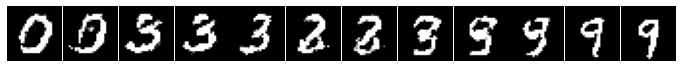

In [116]:
checkpoint_path = path + 'checkpoint_bis_otgan_v1_generator.pt'

n_interpolation = 12
batch_size = 1

plot_interpolation(checkpoint_path, Generator(), n_transitions=n_interpolation, batch_size=batch_size)

**Observation:**

It is intersting to see that the smooth transtion from the digit 0 to the digit 9 passes through the digit 3 (which are all multiplicative of 3).

args 

batch_size 200
n_epochs 500
lr 0.001
beta1 0.9
beta2 0.999
epsilon 1
sinkhorn_iter 10
cuda True


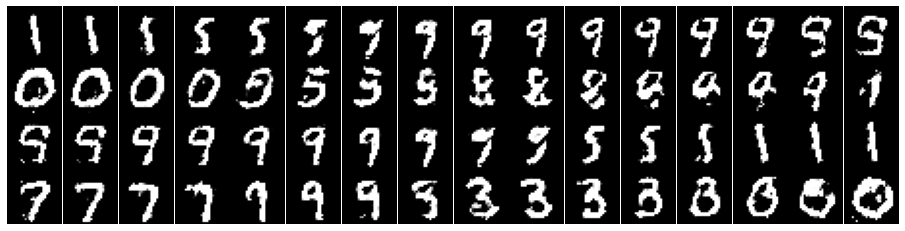

In [120]:
n_interpolation = 16
batch_size = 4

plot_interpolation(checkpoint_path, Generator(), n_transitions=n_interpolation, batch_size=batch_size)

**Observation**:

The first, third and last rows suggest that transition from 1 to 9 passes with 5 and from 7 to 0 passes with 3. It is interesting that all these numbers are prime numbers!

Learning attributes and features in the latent space is an interesting active reasearch area nowadays!

# Final Thoughts

**Conclusions:**
- What we did:
  - Implementation of OT-GAN with Sinkhorn Divergence loss.
  - Test this loss in learning MNIST digits with a very simple model (neural network with 3-layers).

- What we achieved:
  - Samples of relatively high quality compared to the simple architecture used for generation.

- What we observe: 
  - **Sinkhorn Loss is correlated with quality samples**, i.e. a lower sinkhorn loss produces samples of better quality (in contrast of BCE which is not informative).
  - Sinkhorn Loss can be used straightforward with automatic differentiation toolbox.
  - $\epsilon$ controls computational complexity, we can choose a relatively high $\epsilon$ with relatively low Sinkhorn iterations and vice versa.
- What we encountred:
  - Hard in parameters tuning. 
  - Memory limitations, implies lower batch size.
  - Still mode collapsing problem: Not all the digits are generated. This can be solved with further fine-tuning.

**Next Steps:**
- Try to fix discriminator at one point and continue training to see if producted images are "constant".
- Compare quantitatively using the inception score, as mentionned in the article.
- Compare the performance on a toyset with apparent mode to test mode collapse problem.
- Use batch normalization to try to reduce the instability during training. 
- Test with different model architectures (CNN, etc..).
- Benchmark against vanilla GANs with BCE loss.